# Train a Bayesian Layer Model for MNIST classification

In this notebook, we will train an MNIST convolutional classifier with a Bayesian last layer. First, we train a determinstic classifier to obtain a MAP estimate of the weights. Then, we replace the last layer of this model with a Bayesian last layer and train the layer using Stochastic Gradient Hamiltonian Monte Carlo (we keep the backbone fixed). 

## Setup


Import libraries

In [3]:
import importlib
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os

import models.BLL
import models.mnist_classifier_BLL
import train
import sampler


Set the configuration

In [37]:
# 1. Configuration
class Config:
    # Data
    batch_size = 128
    
    # Backbone training
    backbone_epochs = 6
    backbone_lr = 0.001
    backbone_patience = 5
    
    # BLL training
    bll_epochs = 20
    bll_lr = 0.01
    bll_base_C = 0.05
    bll_gauss_sig = 0.1
    
    # SGHMC parameters
    burn_in = 2
    re_burn = 100
    sim_steps = 2      # Save model every N epochs
    N_saves = 20       # Maximum ensemble size
    resample_its = 50  # Resample momentum every N iterations
    resample_prior_its = 100
    nb_its_dev = 1     # Evaluate on validation set every epoch
    
    # Hardware
    device = 'cuda' if torch.cuda.is_available() \
    else 'mps' if torch.backends.mps.is_available() \
    else 'cpu'
    
cfg = Config()

Load the Datasets

In [32]:
# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transform)

# Split training set into train and validation
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

Create a models and results directory if it doesn't exist

In [33]:
models_dir = '../model_saves'
results_dir = '../results'
os.makedirs(models_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

## Training
We'll start with the backbone training.

### Backbone 

Load model

In [39]:
from models.mnist_classifier_BLL import MNISTClassifierBLL
importlib.reload(models.mnist_classifier_BLL)


backbone = MNISTClassifierBLL(device=cfg.device)
print(f"Backbone will run on: {cfg.device}")

Backbone will run on: mps


Train model


Backbone Network:
it 0/6, Jtr = 0.001834, err = 0.000570,    time: 13.178758 seconds

    Jdev = 0.000458, err = 0.000136

best validation error
it 1/6, Jtr = 0.000424, err = 0.000132,    time: 12.154358 seconds

    Jdev = 0.000410, err = 0.000123

best validation error
it 2/6, Jtr = 0.000282, err = 0.000086,    time: 11.951738 seconds

    Jdev = 0.000274, err = 0.000083

best validation error
it 3/6, Jtr = 0.000217, err = 0.000069,    time: 12.201441 seconds

    Jdev = 0.000285, err = 0.000087

it 4/6, Jtr = 0.000172, err = 0.000056,    time: 12.471736 seconds

    Jdev = 0.000266, err = 0.000085

it 5/6, Jtr = 0.000146, err = 0.000048,    time: 13.922614 seconds

    Jdev = 0.000281, err = 0.000075

best validation error
   average time: 17.516799 seconds



<Figure size 640x480 with 0 Axes>

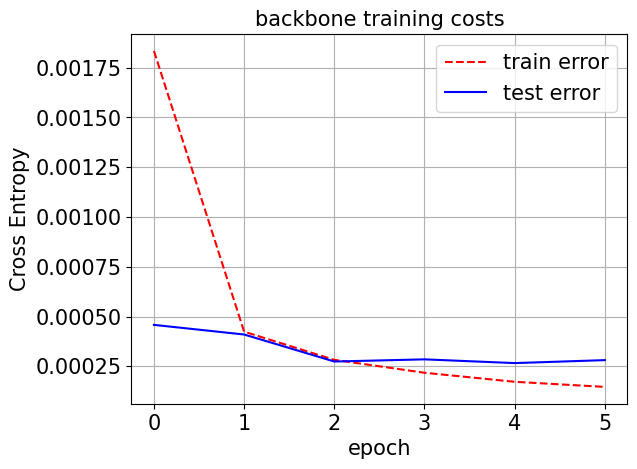


Backbone training completed! Best validation error: 0.0001


In [40]:
from train import train_backbone
importlib.reload(train)

cost_tr, cost_dev, err_tr, err_dev, best_err = train_backbone(
    net=backbone,
    name='mnist_backbone',
    batch_size=cfg.batch_size,
    nb_epochs=cfg.backbone_epochs,
    trainset=trainset,
    valset=valset,
    device=cfg.device,
    lr=cfg.backbone_lr,
    patience=cfg.backbone_patience
)

print(f"\nBackbone training completed! Best validation error: {best_err:.4f}")

## Bayesian Last Layer
Next we'll train the Bayesian last layer on the penultimate layer representations of the backbone.

### Load the model

In [57]:
from models.BLL import BayesianLastLayerCat
importlib.reload(models.BLL)

bll = BayesianLastLayerCat(
    backbone=backbone,
    input_dim=256,  # Matches backbone's encoder output
    output_dim=10,  # MNIST classes
    N_train=len(trainset),
    lr=cfg.bll_lr,
    base_C=cfg.bll_base_C,
    gauss_sig=cfg.bll_gauss_sig,
    device=cfg.device
)

In [58]:
from train import train_BLL_classification
importlib.reload(train)

bll_cost_tr, bll_cost_dev, bll_err_tr, bll_err_dev = train_BLL_classification(
    net=bll,
    name='mnist_bll',
    batch_size=cfg.batch_size,
    nb_epochs=cfg.bll_epochs,
    trainset=trainset,
    valset=valset,
    device=cfg.device,
    burn_in=cfg.burn_in,
    sim_steps=cfg.sim_steps,
    N_saves=cfg.N_saves,
    resample_its=cfg.resample_its,
    resample_prior_its=cfg.resample_prior_its,
    re_burn=cfg.re_burn,
    nb_its_dev=cfg.nb_its_dev
)


Network:

Train:
  init cost variables:
it 0/20, Jtr_pred = 0.000755, err = 0.026104,    time: 11.945296 seconds

 [update_lr] Learning rate: 0.009900  (epoch 0)
    Jdev = 9.909995, err = 0.000061

best test error
it 1/20, Jtr_pred = 0.000064, err = 0.002167,    time: 9.815287 seconds

 [update_lr] Learning rate: 0.009801  (epoch 1)
    Jdev = 10.289207, err = 0.000066

it 2/20, Jtr_pred = 0.000061, err = 0.002000,    time: 8.061469 seconds

 [update_lr] Learning rate: 0.009703  (epoch 2)
 [save_sampled_net] Ensemble size = 1
    Jdev = 10.364863, err = 0.000065

it 3/20, Jtr_pred = 0.000060, err = 0.002229,    time: 8.768946 seconds

 [update_lr] Learning rate: 0.009606  (epoch 3)
    Jdev = 11.228586, err = 0.000075

it 4/20, Jtr_pred = 0.000058, err = 0.002042,    time: 9.782707 seconds

 [update_lr] Learning rate: 0.009510  (epoch 4)
 [save_sampled_net] Ensemble size = 2
    Jdev = 11.000590, err = 0.000064

it 5/20, Jtr_pred = 0.000057, err = 0.002250,    time: 9.820086 seconds


AttributeError: 'BayesianLastLayerCat' object has no attribute 'model'

In [60]:
bll.save_checkpoint(models_dir + '/BLL_checkpoint.pth')

 [save_checkpoint] Saved model state to ../model_saves/BLL_checkpoint.pth


In [63]:
from tqdm import tqdm

print("\nPerforming final evaluation...")

def evaluate_uncertainty(model, loader, n_samples=None):
    correct = []
    uncertainties = {'total': [], 'aleatoric': [], 'epistemic': []}
    
    for x, y in tqdm(loader, desc="Evaluating"):
        x, y = x.to(model.device), y.to(model.device)
        probs, uncertainty = model.predict_with_uncertainty(x)
        
        # Store predictions and uncertainties
        pred = probs.argmax(dim=1)
        correct.extend((pred == y).cpu().numpy())
        
        for k, v in uncertainty.items():
            uncertainties[k].extend(v.cpu().numpy())
    
    return np.array(correct), {k: np.array(v) for k, v in uncertainties.items()}

# Run final evaluation
correct, uncertainties = evaluate_uncertainty(bll, testloader, cfg.N_saves)
accuracy = correct.mean()

print(f"\nFinal Test Accuracy: {accuracy:.4f}")

# 8. Visualization of Uncertainties
plt.figure(figsize=(15, 5))

# Total uncertainty
plt.subplot(131)
plt.hist(uncertainties['total_entropy'][correct], alpha=0.5, label='Correct', density=True)
plt.hist(uncertainties['total_entropy'][~correct], alpha=0.5, label='Incorrect', density=True)
plt.xlabel('Total Uncertainty')
plt.ylabel('Density')
plt.legend()

# Aleatoric uncertainty
plt.subplot(132)
plt.hist(uncertainties['aleatoric_entropy'][correct], alpha=0.5, label='Correct', density=True)
plt.hist(uncertainties['aleatoric_entropy'][~correct], alpha=0.5, label='Incorrect', density=True)
plt.xlabel('Aleatoric Uncertainty')
plt.legend()

# Epistemic uncertainty
plt.subplot(133)
plt.hist(uncertainties['epistemic_entropy'][correct], alpha=0.5, label='Correct', density=True)
plt.hist(uncertainties['epistemic_entropy'][~correct], alpha=0.5, label='Incorrect', density=True)
plt.xlabel('Epistemic Uncertainty')
plt.legend()

plt.tight_layout()
plt.show()


Performing final evaluation...


Evaluating:   0%|          | 0/157 [00:04<?, ?it/s]


KeyError: 'total_entropy'